In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import igraph as ig
import numpy as np
import seaborn as sns
import json

import collections
import xnetwork as xn
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import numpy as np
from scipy import stats

In [2]:
import sys
sys.path.append("../../src/")

In [3]:
from network.network_tools import sorting, infos

In [4]:
unarxiv_df = pd.read_csv('../../data/unarxiv/unarxiv_context_citations_labels.csv')
unarxiv_info = pd.read_csv('../../data/unarxiv/unarxiv_info.csv')

/tmp/ipykernel_27703/2590621313.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  unarxiv_df = pd.read_csv('../../data/unarxiv/unarxiv_context_citations_labels.csv')


In [5]:
unarxiv_df['qtd_tokens'] = unarxiv_df.text.apply(lambda x: len(x.split()))
unarxiv_df['cited_ids'] = unarxiv_df.cited_ids.apply(eval)
unarxiv_df['qtd_citations'] = unarxiv_df.cited_ids.apply(len)

In [6]:
# Fixing type and drop duplicates
unarxiv_df = unarxiv_df.explode('cited_ids')
unarxiv_df['cited_ids'] = unarxiv_df['cited_ids'].astype(str)
unarxiv_df['id'] = unarxiv_df['id'].astype(str)
unarxiv_df.drop_duplicates(inplace=True)

In [7]:
unarxiv_info = unarxiv_info.drop_duplicates(subset=['id'])
unarxiv_info = unarxiv_info.replace('nan', 'Unknown')

In [8]:
unarxiv_info['discipline'] = unarxiv_info['discipline'].astype(str)
unarxiv_info['id'] = unarxiv_info['id'].astype(str)

In [9]:
df = unarxiv_df.copy()

## Graph

In [10]:
# Remove Intents
G_full = nx.from_pandas_edgelist(df, source="id", target="cited_ids", create_using=nx.DiGraph())

# df_background = df[df.label != 'background']
# G_filtered_background = nx.from_pandas_edgelist(df_background, source="id", target="cited_ids", create_using=nx.DiGraph())

# df_result = df[df.label != 'result']
# G_filtered_result = nx.from_pandas_edgelist(df_result, source="id", target="cited_ids", create_using=nx.DiGraph())

# df_method = df[df.label != 'method']
# G_filtered_method = nx.from_pandas_edgelist(df_method, source="id", target="cited_ids", create_using=nx.DiGraph())

In [11]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, kendalltau


def compute_centrality(G, measure="closeness"):
    """
    Compute a centrality dictionary {node: score} for a directed graph G.
    Extend/modify to match what you used in the paper.
    """
    if measure == "closeness":
        return nx.closeness_centrality(G)
    elif measure == "betweenness":
        return nx.betweenness_centrality(G, normalized=True)
    elif measure == "indegree":
        # degree only counting incoming edges
        return dict(G.in_degree())
    elif measure == "pagerank":
        return nx.pagerank(G, alpha=0.85)
    else:
        raise ValueError(f"Unknown measure: {measure}")


def rank_correlation(scores_full, scores_perturbed, method="spearman"):
    """
    Compute rank-based correlation between two centrality dictionaries
    restricted to nodes present in both.
    """
    nodes = sorted(set(scores_full.keys()) & set(scores_perturbed.keys()))
    if not nodes:
        return np.nan

    x = np.array([scores_full[n] for n in nodes])
    y = np.array([scores_perturbed[n] for n in nodes])

    if method == "spearman":
        rho, _ = spearmanr(x, y)
    elif method == "kendall":
        rho, _ = kendalltau(x, y)
    else:
        raise ValueError("method must be 'spearman' or 'kendall'")

    return rho


In [12]:
def build_intent_removed_graph(df_edges, intent_to_remove):
    """
    Remove all edges with the given intent from df_edges and build a DiGraph.
    """
    df_sub = df_edges[df_edges["label"] != intent_to_remove]
    G = nx.from_pandas_edgelist(
        df_sub,
        source="id",
        target="cited_ids",
        create_using=nx.DiGraph()
    )
    return G


def correlation_for_intent_removal(df_edges, G_full, measure="closeness",
                                   intent_to_remove="Background",
                                   corr_method="spearman"):
    """
    Compute rank correlation between full network and a network with all
    edges of 'intent_to_remove' removed.
    """
    # full centrality once (reuse across tests for speed)
    scores_full = compute_centrality(G_full, measure=measure)

    # filtered graph & centrality
    G_removed = build_intent_removed_graph(df_edges, intent_to_remove)
    scores_removed = compute_centrality(G_removed, measure=measure)

    rho = rank_correlation(scores_full, scores_removed, method=corr_method)
    return rho


In [13]:
rho_bg = correlation_for_intent_removal(df, G_full, measure="closeness",
                                        intent_to_remove="background",
                                        corr_method="spearman")

rho_meth = correlation_for_intent_removal(df, G_full, measure="closeness",
                                          intent_to_remove="method",
                                          corr_method="spearman")

rho_res = correlation_for_intent_removal(df, G_full, measure="closeness",
                                         intent_to_remove="result",
                                         corr_method="spearman")
print("Spearman (no BG, no Method, no Result):", rho_bg, rho_meth, rho_res)


Spearman (no BG, no Method, no Result): 0.819265727891595 0.949863126650544 0.996752873674025


In [14]:
import random

def random_removal_correlations(df_edges, G_full, measure="closeness",
                                corr_method="spearman",
                                intent_ref="Result",
                                n_runs=50,
                                restrict_to_non_ref=False,
                                random_state=42):
    """
    Remove the same number of edges as the count of 'intent_ref',
    but sampled at random, and compute correlation vs full.

    Parameters
    ----------
    df_edges : DataFrame with columns ["id", "cited_ids", "intent"]
    G_full   : full DiGraph
    measure  : centrality measure name
    corr_method : "spearman" or "kendall"
    intent_ref  : which intent defines N_ref (e.g. "Result")
    n_runs      : number of random trials
    restrict_to_non_ref : if True, sample only from edges whose intent != intent_ref
    """
    rng = random.Random(random_state)

    # centrality on full network (compute once)
    scores_full = compute_centrality(G_full, measure=measure)

    # how many edges of the reference intent?
    mask_ref = (df_edges["label"] == intent_ref)
    N_ref = mask_ref.sum()

    if restrict_to_non_ref:
        pool_df = df_edges[~mask_ref].copy()
    else:
        pool_df = df_edges.copy()

    if N_ref > len(pool_df):
        raise ValueError("Not enough edges to sample from for this configuration.")

    corrs = []

    for i in range(n_runs):
        # sample N_ref edges uniformly at random
        sample_idx = pool_df.sample(
            n=N_ref,
            replace=False,
            random_state=rng.randint(0, 10**9)
        ).index

        df_sub = df_edges.drop(index=sample_idx)

        G_rand = nx.from_pandas_edgelist(
            df_sub,
            source="id",
            target="cited_ids",
            create_using=nx.DiGraph()
        )

        scores_rand = compute_centrality(G_rand, measure=measure)
        rho = rank_correlation(scores_full, scores_rand, method=corr_method)
        corrs.append(rho)

    return np.array(corrs)


In [22]:
%%time
# 1) Observed effect of removing all Result edges
rho_res_observed = correlation_for_intent_removal(
    df, G_full,
    measure="closeness",
    intent_to_remove="result",
    corr_method="spearman"
)

# 2) Null model: remove same number of random edges as there are Result edges
rho_res_random = random_removal_correlations(
    df, G_full,
    measure="closeness",
    corr_method="spearman",
    intent_ref="result",
    n_runs=100,
    restrict_to_non_ref=False   # sample from all edges
)

print("Observed  rho (remove all Result):", rho_res_observed)
print("Random   rho mean:", rho_res_random.mean())
print("Random   rho std :", rho_res_random.std())
print("Random   rho min :", rho_res_random.min())
print("Random   rho max :", rho_res_random.max())

# # Empirical p-value: how often random is <= observed?
# p_val = (rho_res_random <= rho_res_observed).mean()
# print("Empirical p-value:", p_val)


Observed  rho (remove all Result): 0.996752873674025
Random   rho mean: 0.9735933956831091
Random   rho std : 0.0008787858087666187
Random   rho min : 0.971365301758579
Random   rho max : 0.9753888514970444
CPU times: user 3min 51s, sys: 131 ms, total: 3min 51s
Wall time: 3min 52s


In [23]:
z_score = (rho_res_observed - rho_res_random.mean()) / rho_res_random.std()  
print(f"z-score is: {z_score}")

z-score is: 26.35395082610672


In [24]:
# 1) Observed effect of removing all Background edges
rho_res_observed = correlation_for_intent_removal(
    df, G_full,
    measure="closeness",
    intent_to_remove="background",
    corr_method="spearman"
)

# 2) Null model: remove same number of random edges as there are Background edges
rho_res_random = random_removal_correlations(
    df, G_full,
    measure="closeness",
    corr_method="spearman",
    intent_ref="background",
    n_runs=100,
    restrict_to_non_ref=False   # sample from all edges
)

print("Observed  rho (remove all Background):", rho_res_observed)
print("Random   rho mean:", rho_res_random.mean())
print("Random   rho std :", rho_res_random.std())
print("Random   rho min :", rho_res_random.min())
print("Random   rho max :", rho_res_random.max())

# # Empirical p-value: how often random is <= observed?
# p_val = (rho_res_random <= rho_res_observed).mean()
# print("Empirical p-value:", p_val)


Observed  rho (remove all Background): 0.819265727891595
Random   rho mean: 0.7612440030935003
Random   rho std : 0.0020705564128635184
Random   rho min : 0.755553033052166
Random   rho max : 0.7674262214190609


In [25]:
z_score = (rho_res_observed - rho_res_random.mean()) / rho_res_random.std()  
print(f"z-score is: {z_score}")

z-score is: 28.022286394917597


In [15]:
# 1) Observed effect of removing all Background edges
rho_res_observed = correlation_for_intent_removal(
    df, G_full,
    measure="closeness",
    intent_to_remove="method",
    corr_method="spearman"
)

# 2) Null model: remove same number of random edges as there are Background edges
rho_res_random = random_removal_correlations(
    df, G_full,
    measure="closeness",
    corr_method="spearman",
    intent_ref="method",
    n_runs=100,
    restrict_to_non_ref=False   # sample from all edges
)

print("Observed  rho (remove all Method):", rho_res_observed)
print("Random   rho mean:", rho_res_random.mean())
print("Random   rho std :", rho_res_random.std())
print("Random   rho min :", rho_res_random.min())
print("Random   rho max :", rho_res_random.max())

# # Empirical p-value: how often random is <= observed?
# p_val = (rho_res_random <= rho_res_observed).mean()
# print("Empirical p-value:", p_val)

Observed  rho (remove all Method): 0.949863126650544
Random   rho mean: 0.8148650186654776
Random   rho std : 0.0015789127825377638
Random   rho min : 0.8103874317256298
Random   rho max : 0.8183621482240023


In [16]:
z_score = (rho_res_observed - rho_res_random.mean()) / rho_res_random.std()  
print(f"z-score is: {z_score}")

z-score is: 85.50067456423139


In [ ]:
# zscore background 28.02 vs result 26.35

## Remove same quantity

In [14]:
import networkx as nx
import numpy as np
from scipy.stats import spearmanr
import random
import pandas as pd


In [15]:
def compute_centrality(G, measure="closeness"):
    """
    Returns a dict: node -> centrality score.
    Extend with other measures as needed.
    """
    if measure == "closeness":
        return nx.closeness_centrality(G)
    elif measure == "betweenness":
        return nx.betweenness_centrality(G, normalized=True)
    elif measure == "pagerank":
        return nx.pagerank(G)
    elif measure == "indegree":
        # in-degree centrality (normalized like NetworkX)
        n = G.number_of_nodes()
        return {n_id: d / (n - 1) for n_id, d in G.in_degree()}
    else:
        raise ValueError(f"Unknown measure: {measure}")


In [16]:
def spearman_vs_full(scores_full, scores_filtered):
    """
    Compute Spearman rho between full and filtered centrality scores.
    Only over nodes present in BOTH dicts.
    """
    common_nodes = list(set(scores_full.keys()) & set(scores_filtered.keys()))
    if len(common_nodes) < 2:
        return np.nan

    x = [scores_full[n] for n in common_nodes]
    y = [scores_filtered[n] for n in common_nodes]

    rho, _ = spearmanr(x, y)
    return rho


In [27]:
def compare_background_vs_result_same_k(
    df_edges,
    G_full,
    intent_col="intent",
    bg_label="Background",
    res_label="Result",
    measure="closeness",
    n_iter=100,
    k=None,
    seed=42,
):
    random.seed(seed)
    np.random.seed(seed)

    # Precompute full centrality once
    scores_full = compute_centrality(G_full, measure=measure)

    # Build edge lists by intent, as (u, v) tuples
    bg_edges = list(
        df_edges[df_edges[intent_col] == bg_label][["id", "cited_ids"]]
        .itertuples(index=False, name=None)
    )
    res_edges = list(
        df_edges[df_edges[intent_col] == res_label][["id", "cited_ids"]]
        .itertuples(index=False, name=None)
    )

    n_bg = len(bg_edges)
    n_res = len(res_edges)
    print(f"#background edges: {n_bg}, #result edges: {n_res}")

    # If k not given, use the minimum so both can be sampled
    if k is None:
        k = min(n_bg, n_res)
    print(f"Sampling k = {k} edges from each intent per iteration.")

    rhos_bg = []
    rhos_res = []

    for it in range(n_iter):
        # Sample edges
        sample_bg = random.sample(bg_edges, k)
        sample_res = random.sample(res_edges, k)

        # Remove background edges
        G_bg = G_full.copy()
        G_bg.remove_edges_from(sample_bg)
        scores_bg = compute_centrality(G_bg, measure=measure)
        rho_bg = spearman_vs_full(scores_full, scores_bg)
        rhos_bg.append(rho_bg)

        # Remove result edges
        G_res = G_full.copy()
        G_res.remove_edges_from(sample_res)
        scores_res = compute_centrality(G_res, measure=measure)
        rho_res = spearman_vs_full(scores_full, scores_res)
        rhos_res.append(rho_res)

    rhos_bg = np.array(rhos_bg)
    rhos_res = np.array(rhos_res)

    # Summary
    summary = {
        "rho_bg_mean": float(rhos_bg.mean()),
        "rho_bg_std": float(rhos_bg.std()),
        "rho_res_mean": float(rhos_res.mean()),
        "rho_res_std": float(rhos_res.std()),
        "rho_diff_mean": float((rhos_res - rhos_bg).mean()),  # >0 → bg more harmful
    }

    # --- APPROACH 1: Bootstrap/Empirical P-Value (Recommended for your data) ---
    # We count how many times the Null Hypothesis (bg >= res) appeared in the simulation.
    # If this number is very small, we reject the Null.
    n_supporting_null = np.sum(rhos_bg >= rhos_res)
    
    # Calculate p-value with Laplace smoothing (add-one)
    p_value_empirical = (n_supporting_null + 1) / (n_iter + 1)
    
    print(f"Empirical p-value: {p_value_empirical:.5f}")
    
    # --- APPROACH 2: Paired T-Test (Standard Parametric Test) ---
    # We test if 'rhos_bg' is significantly LESS than 'rhos_res'.
    t_stat, p_value_ttest = stats.ttest_rel(rhos_bg, rhos_res, alternative='less')

    print(f"T-test p-value: {p_value_ttest:.5e}")

    summary["p_empirical_bg_more_harmful"] = float(p_value_empirical)
    summary["p_ttest_bg_more_harmful"] = float(p_value_ttest)

    return rhos_bg, rhos_res, summary


In [23]:
df.label.value_counts()

label
background    196187
method        100329
result          6856
Name: count, dtype: int64

In [28]:
k_vals = []
rho_bg_mean = [] 
rho_bg_std = []
rho_res_mean = []
rho_res_std = []

for k in [100, 500, 1000, 2500, 5000, 6856]:
    rhos_bg, rhos_res, summary = compare_background_vs_result_same_k(
        df_edges=df,
        G_full=G_full,
        intent_col="label",
        bg_label="background",
        res_label="result",
        measure="closeness",   # or "pagerank", "betweenness", etc.
        n_iter=100,
        k=k,                # will use min(#bg, #res)
    )
    k_vals.append(k)
    rho_bg_mean.append(summary.get('rho_bg_mean'))
    rho_bg_std.append(summary.get('rho_bg_std'))
    rho_res_mean.append(summary.get('rho_res_mean'))
    rho_res_std.append(summary.get('rho_res_std'))

    print(summary)


#background edges: 196187, #result edges: 6856
Sampling k = 100 edges from each intent per iteration.
Empirical p-value: 0.63366
T-test p-value: 9.99840e-01
{'rho_bg_mean': 0.9995019884378218, 'rho_bg_std': 9.770685830384529e-05, 'rho_res_mean': 0.9994472598140244, 'rho_res_std': 9.877050984169382e-05, 'rho_diff_mean': -5.472862379720888e-05, 'p_empirical_bg_more_harmful': 0.6336633663366337, 'p_ttest_bg_more_harmful': 0.999840319459571}
#background edges: 196187, #result edges: 6856
Sampling k = 500 edges from each intent per iteration.
Empirical p-value: 0.88119
T-test p-value: 1.00000e+00
{'rho_bg_mean': 0.9975271359162575, 'rho_bg_std': 0.00020370129824918065, 'rho_res_mean': 0.9972137297896394, 'rho_res_std': 0.0001830128283377887, 'rho_diff_mean': -0.0003134061266180199, 'p_empirical_bg_more_harmful': 0.8811881188118812, 'p_ttest_bg_more_harmful': 1.0}
#background edges: 196187, #result edges: 6856
Sampling k = 1000 edges from each intent per iteration.
Empirical p-value: 0.95050

# background edges: 196187, #result edges: 6856
```
Sampling k = 100 edges from each intent per iteration.
{'rho_bg_mean': 0.9995019884378218, 'rho_bg_std': 9.770685830384529e-05, 'rho_res_mean': 0.9994472598140244, 'rho_res_std': 9.877050984169382e-05, 'rho_diff_mean': -5.472862379720888e-05, 'p_bg_more_harmful': 0.37623762376237624}
```

```
Sampling k = 500 edges from each intent per iteration.
{'rho_bg_mean': 0.9975271359162575, 'rho_bg_std': 0.00020370129824918065, 'rho_res_mean': 0.9972137297896394, 'rho_res_std': 0.0001830128283377887, 'rho_diff_mean': -0.0003134061266180199, 'p_bg_more_harmful': 0.12871287128712872}
```

```
Sampling k = 1000 edges from each intent per iteration.
{'rho_bg_mean': 0.9951061504080504, 'rho_bg_std': 0.00033428588091652064, 'rho_res_mean': 0.9945104455992001, 'rho_res_std': 0.0002591417126782922, 'rho_diff_mean': -0.0005957048088504413, 'p_bg_more_harmful': 0.0594059405940594}
```

```
Sampling k = 2500 edges from each intent per iteration.
{'rho_bg_mean': 0.9877863558061644, 'rho_bg_std': 0.0005061721064756449, 'rho_res_mean': 0.9867247115880944, 'rho_res_std': 0.0003302358891115352, 'rho_diff_mean': -0.0010616442180700568, 'p_bg_more_harmful': 0.039603960396039604}
```

```
Sampling k = 5000 edges from each intent per iteration.
{'rho_bg_mean': 0.9757204758079695, 'rho_bg_std': 0.0006724826201079698, 'rho_res_mean': 0.9745037763016168, 'rho_res_std': 0.0002871274120521467, 'rho_diff_mean': -0.0012166995063525832, 'p_bg_more_harmful': 0.04950495049504951}
```

```
Sampling k = 6856 edges from each intent per iteration.
{'rho_bg_mean': 0.9669193958578962, 'rho_bg_std': 0.0008121981282271554, 'rho_res_mean': 0.9659350219607581, 'rho_res_std': 3.3306690738754696e-16, 'rho_diff_mean': -0.0009843738971385884, 'p_bg_more_harmful': 0.16831683168316833}
```

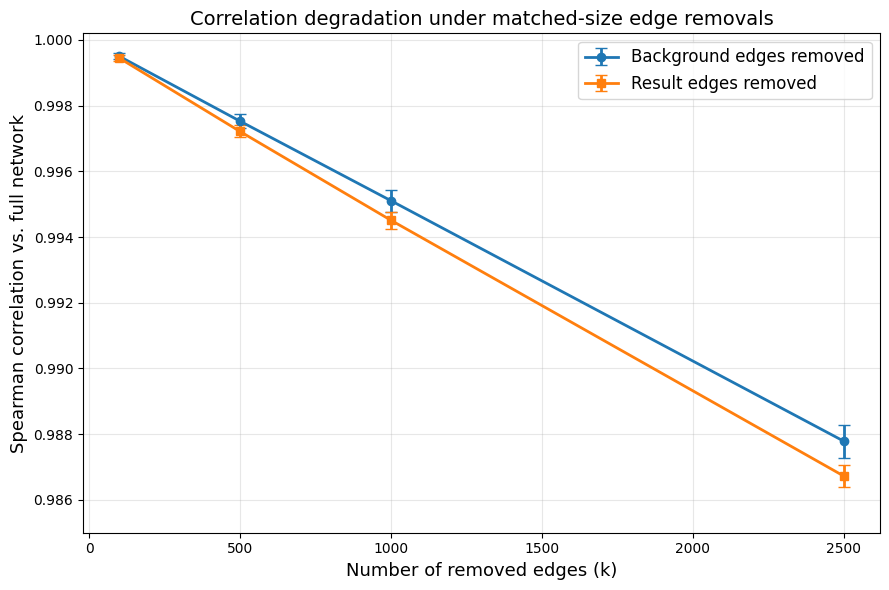

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,6))

# Plot Background
plt.errorbar(
    k_vals, rho_bg_mean, yerr=rho_bg_std,
    fmt='-o', capsize=4, linewidth=2,
    label="Background edges removed"
)

# Plot Result
plt.errorbar(
    k_vals, rho_res_mean, yerr=rho_res_std,
    fmt='-s', capsize=4, linewidth=2,
    label="Result edges removed"
)

plt.xlabel("Number of removed edges (k)", fontsize=13)
plt.ylabel("Spearman correlation vs. full network", fontsize=13)
plt.title("Correlation degradation under matched-size edge removals", fontsize=14)

plt.ylim(0.985, 1.0002)   # focus on detail
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
